### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os

from tensorflow.keras.layers import Lambda, Dense, MaxPool2D, MaxPooling2D, AvgPool2D, Flatten, Layer, Dropout, Input, Subtract, Multiply, Add, InputLayer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils  import plot_model

In [2]:
import os

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../utilities')
from utilities import (
    load_image,
    show_image,
    vgg19_process_image,
    vgg19_deprocess_image,
    precomputed_loss,
    get_image_from_model,
    gram_matrix, 
    Source,
    Timer,
    dummy,
    class_names,
)

### Build a Style Extraction Model

In [5]:
base_model = load_model('../classification/logs/models/vgg19-INet-down2-b.hdf5')

In [6]:
width = height = 896

In [ ]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [7]:
input_ = Input(shape = (width, height, 3))
signal = input_

style_outputs = []
for layer in base_model.layers:
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dense):
        break
    else:
        signal = layer(signal)
    
    if layer.name in style_layers:
        style_outputs.append(Lambda(gram_matrix, name = f'gram_{layer.name}')(signal))
        
extract_model = Model(inputs = [input_], outputs = style_outputs, name = 'extractive_model')

### Extract Some Styles

In [8]:
# Step 1: Pick an artwork for each artist, compute activations
artists = class_names.tolist()

Timer.start()
np.random.seed(42)
def get_activations(artist):
    artist_dir = f'../dataset/images/train/{artist}/'
    possible_choices = os.listdir(artist_dir)
    possible_choices = filter(lambda f : f.endswith('.jpg'), possible_choices)
    choice = np.random.choice(list(possible_choices))
    image  = load_image(artist_dir + choice)
    image  = vgg19_process_image(image)
    image  = tf.image.resize(image, (width, height))
    image  = tf.expand_dims(image, axis = 0)
    activations = extract_model(image)
    return activations
    
activations = [get_activations(artist) for artist in artists]
Timer.end()

7.532 seconds elapsed


In [9]:
# Step 2: Save those activations to disk
Timer.start()
for artist, activations in zip(artists, activations):
    file_name = f'./style-activations/{artist}.npz'
    np_data   = [tensor.numpy() for tensor in activations]
    np.savez(file_name, *np_data)
Timer.end()

0.990 seconds elapsed


## Build a Dreaming Model
Inputs will be: a dummy input and  desired style activations

In [10]:
# Should be moved to utilities
from tensorflow.keras.constraints import Constraint

class RemainImage(Constraint):
    def __init__(self, rate = 1.0):
        super().__init__()
        self.rate = rate
    
    def __call__(self, kernel):
        return (self.rate       * tf.clip_by_value(kernel, -150, 150) + 
                (1 - self.rate) * kernel)

In [157]:
style_content_weighting = 100.

style_layer_weighting   = tf.constant(1/len(style_outputs) * style_content_weighting * (1/4))

input_       = Input(shape = (), batch_size = 1, name = 'dummy_input')
image_layer  = Source((1, width, height, 3), name = 'image', kernel_constraint = RemainImage(0.9))
signal       = image_layer(input_)

output_layers = {
#     'dense_2'            : 1.0,
    'block4_conv1'       : 0.1,
    'block5_conv1'       : 0.1,
}
max_pool_extracted_layers = False

# Alias
if 'dense_2' in output_layers:
    output_layers['fc2'] = output_layers['dense_2']
if 'dense_1' in output_layers:
    output_layers['fc1'] = output_layers['dense_1']

output_count = 0
style_input_count  = 0
outputs = []
inputs  = [input_]
def get_summary_function(weight):
    def summary_fn(activation):
        # activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn
base_model_layers = base_model.layers

# Add resampling before flattening to allow larger images
flatten_index     = next(filter(
                            lambda i : isinstance(base_model_layers[i], Flatten), 
                            range(len(base_model_layers))))
resize_layer      = Lambda(lambda tensor : tf.image.resize(tensor, (7,7), method = 'gaussian'),
                           name = 'resize')
base_model_layers.insert(flatten_index, resize_layer)

for layer in base_model_layers:
    layer.trainable = False
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dropout):
        continue
    elif isinstance(layer, MaxPooling2D):
        layer = AvgPool2D().from_config(layer.get_config())
    elif layer.name in ['dense_2', 'fc2']:
        # Top layer requires different activations
        top_config = layer.get_config()
        top_config['activation'] = 'elu'
        layer     = layer.from_config(top_config)
        top_layer = layer


    signal = layer(signal)
    
    if layer.name in output_layers:
        output_count += 1
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]), name = f'compute_gain_{output_count}')
        # Optional: max pool the layer first (!!)
        if max_pool_extracted_layers:
            max_pool = GlobalMaxPooling2D(name = f'focus_{output_count}')
            total_activation = summarizer_layer(max_pool(signal))
        else:
            total_activation = summarizer_layer(signal)
        outputs.append(total_activation)


    if layer.name in style_layers:
        output_count += 1
        gram_matrix = Lambda(gram_matrix, name = f'gram_{layer.name}')
        gram_signal = gram_matrix(signal)
        batch_input_shape = gram_signal.shape
        input_     = Input(shape = batch_input_shape[1:], batch_size=batch_input_shape[0], 
                           name = f'arr_{style_input_count}')
        style_input_count += 1
        inputs.append(input_)
        difference = Subtract()([input_, gram_signal])
        square     = Lambda(tf.square, name = f'square_{output_count}')(difference)
        reduce = Lambda(lambda t : tf.reduce_mean(t, axis = [1,2]), name = f'mean_{output_count}')(square)
        scale  = Lambda(lambda x : x * style_layer_weighting, name = f'weight_{output_count}')(reduce)
        outputs.append(scale)

final_output = Add()(outputs)
        
model = Model(inputs = inputs, outputs = final_output)

# Weights for the top layer (with artist activations)
#  were reset; restore them
top_layer.set_weights(base_model.layers[-1].get_weights())

### Load the Style, Reset the Model, Fit the Model

In [159]:
# Load the image
image_path = '../dream-base-images/IMG_0325.jpg'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 90463559680.0000
Epoch 2/5
1/1 [==============================] - 0s 282ms/step - loss: 74573217792.0000
Epoch 3/5
1/1 [==============================] - 0s 280ms/step - loss: 59125301248.0000
Epoch 4/5
1/1 [==============================] - 0s 277ms/step - loss: 46840557568.0000
Epoch 5/5
1/1 [==============================] - 0s 282ms/step - loss: 38580498432.0000


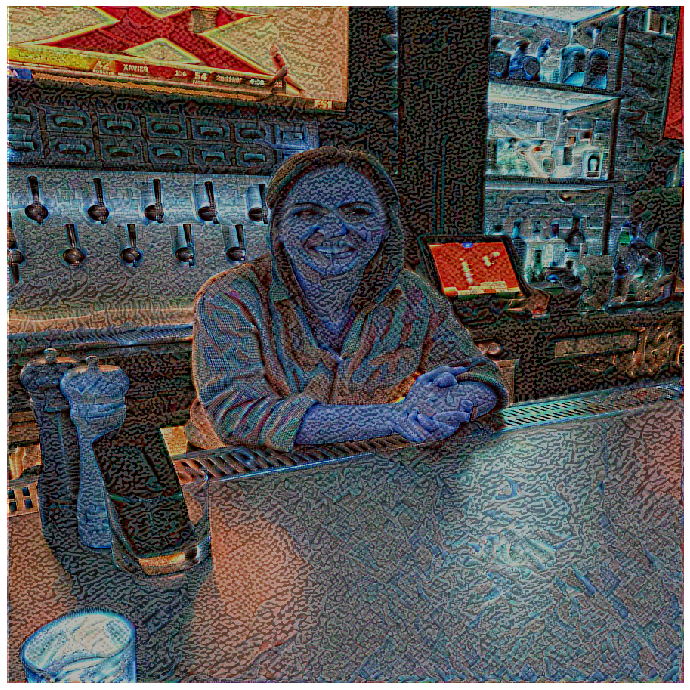

In [169]:
# Load the Style and set up the dataset

style_path   = './style-activations/Pablo Picasso.npz'

with np.load(style_path, allow_pickle = False) as style_data:
    style_inputs = [tf.convert_to_tensor(value) for value in style_data.values()]
style_data.close()

inputs = [dummy] + style_inputs
ds = tf.data.Dataset.from_tensor_slices((tuple(inputs), dummy))
ds = ds.batch(1)
ds = ds.cache()

image_layer = model.get_layer('image')
image_layer.set_weights([image.numpy()])

# Poor man's learning rate scheduler; for tuning
adam = tf.optimizers.Adam(learning_rate = 20.0)
model.compile(optimizer = adam, loss = precomputed_loss)

history = model.fit(ds, epochs = 5)

img = get_image_from_model(model)
show_image(img)

In [ ]:
plot_model(model)